<h1>TD3 : Let's play with faces</h1>  
Part 1 - Transfert Learning (create embeddings)

S. Delprat, INSA Hauts-de-France    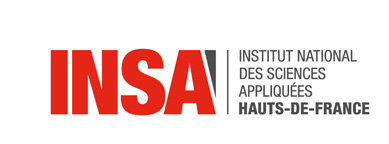


For this exercice, we are going to compute a set of embeddings vector from a pre-trained neural network. The selected pre-trained network is a Inception-Resnet-v1 trained on the VGG Face2 dataset. This network has been trained to classify celebrity pictures of size 160x160 pixels. The network comprises a CNN part whose architecture is a mix of Inception (GoogleNet) and Res-Net. It generate an embedding vector which is processed by the classifiction head. The source code of this network is "inception_resnet_v1.py", feel free to have a look.

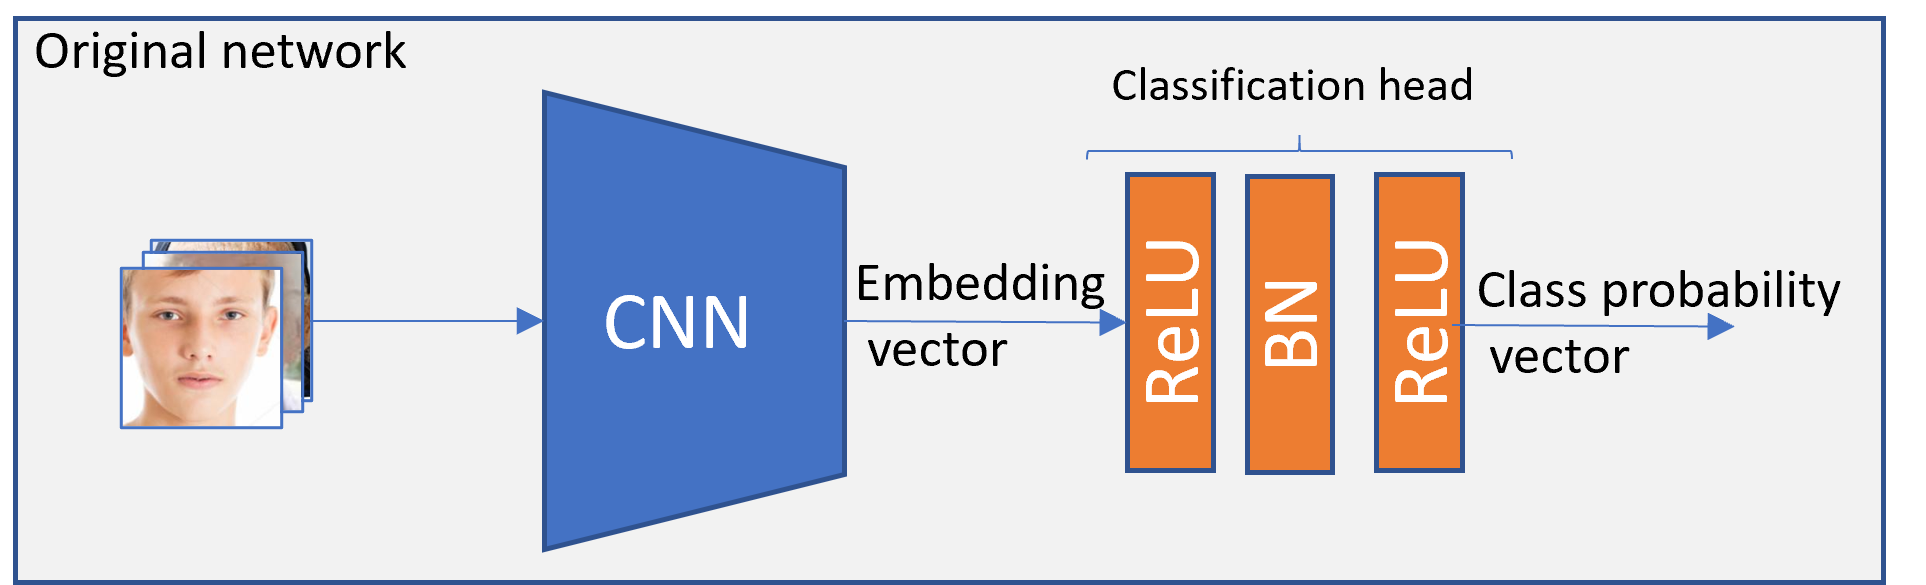

The transfer learning approach consists in reusing the CNN part to produce emebedding vectors. This embedding vectors are then used for other purposes, in this exercise session, they will be used to predict the perceived age of a person and to find celebrity lookalike.  
So the first step is to disable the classification head from the original network. Amongst all the possibility, one can replace the original classification hear layers by identity layers.  
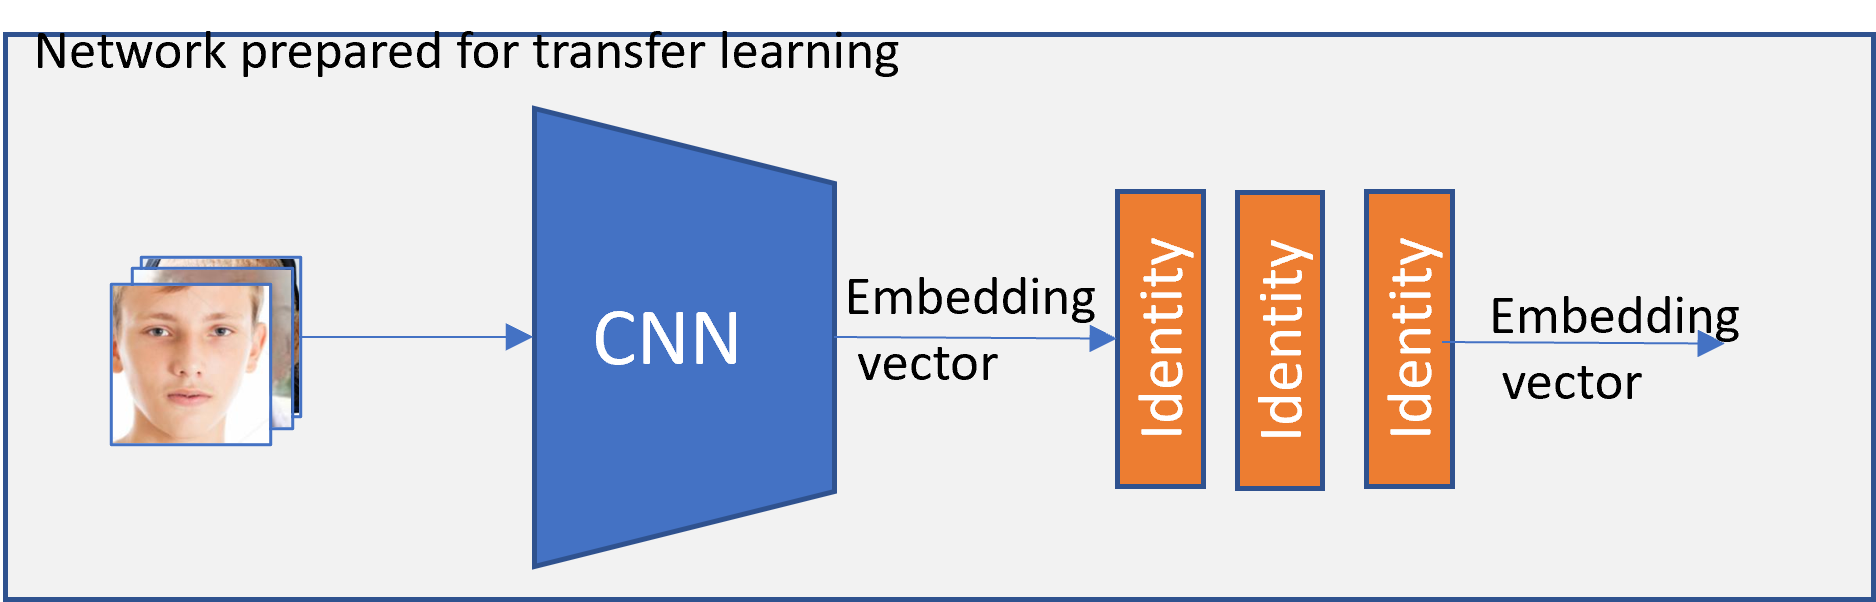

In order to train a network to predict the perceived age from an image,  we are going to use the first approach presented in the lecture: The whole image dataset will be processed by the modified network and the resulting embedding vectors will be stored on a disk. The benefits is that the image dataset will only be processed once by the CNN part and thus training a new classification/regression head should be very fast.
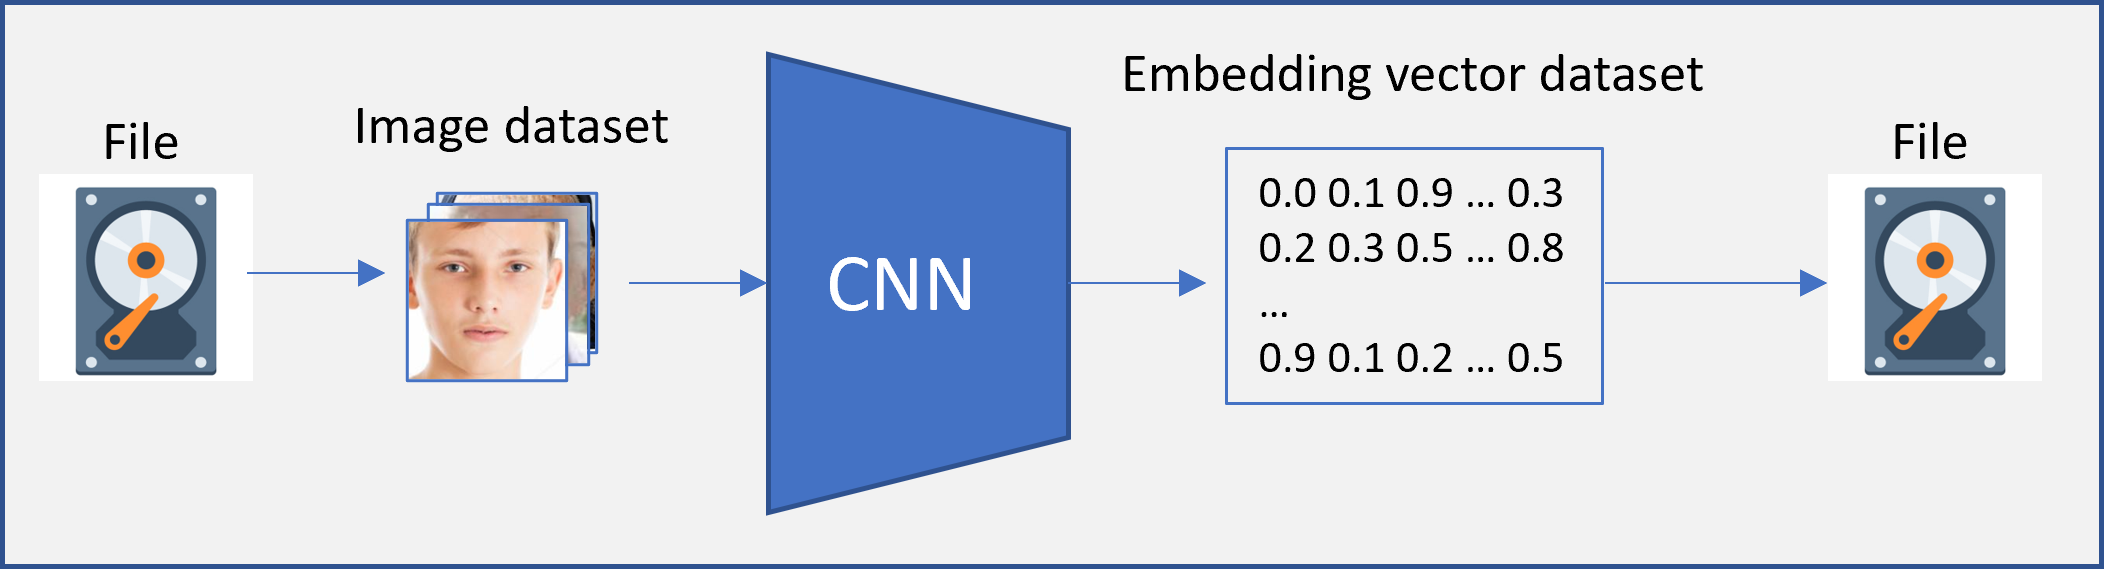

In [47]:
# Import and install inception-resnet-v1 files
import os
import zipfile
extractFolder='../data/processed/InceptionResnetV1'
inputFolder='../data/raw/'
with zipfile.ZipFile(os.path.join(inputFolder,"InceptionResnetV1.zip"), 'r') as zip_ref:
    zip_ref.extractall(extractFolder)

In [48]:
# Import UTK Face dataset
extractFolder='../data/processed/UTKFace'
inputFolder='../data/raw/'
baseFolder=os.path.join(extractFolder,'UTKFace')
if not os.path.isdir(baseFolder):
    print('Extracting the dataset')
    with zipfile.ZipFile(os.path.join(inputFolder,"UTKFace.zip"), 'r') as zip_ref:
        zip_ref.extractall(extractFolder)

Extracting the dataset


In [49]:
# %pip install facenet-pytorch

In [50]:
import torch
import matplotlib.pyplot as plt
from glob import glob
import random
from torchinfo import summary
import os
import pickle
from facenet_pytorch import MTCNN

In [51]:
help(MTCNN)

Help on class MTCNN in module facenet_pytorch.models.mtcnn:

class MTCNN(torch.nn.modules.module.Module)
 |  MTCNN(image_size=160, margin=0, min_face_size=20, thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True, select_largest=True, selection_method=None, keep_all=False, device=None)
 |
 |  MTCNN face detection module.
 |
 |  This class loads pretrained P-, R-, and O-nets and returns images cropped to include the face
 |  only, given raw input images of one of the following types:
 |      - PIL image or list of PIL images
 |      - numpy.ndarray (uint8) representing either a single image (3D) or a batch of images (4D).
 |  Cropped faces can optionally be saved to file
 |  also.
 |
 |  Keyword Arguments:
 |      image_size {int} -- Output image size in pixels. The image will be square. (default: {160})
 |      margin {int} -- Margin to add to bounding box, in terms of pixels in the final image.
 |          Note that the application of the margin differs slightly from the davidsa

Random seed

In [52]:
import numpy as np
DEFAULT_RANDOM_SEED=42
def seedBasic(seed=DEFAULT_RANDOM_SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def seedTorch(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# basic + tensorflow + torch
def seedEverything(seed=DEFAULT_RANDOM_SEED):
    seedBasic(seed)
    seedTorch(seed)

seedEverything()

Configuration of the hyperparameters

In [53]:
experimentName                          = "Part1"
maxImgsTrain,maxImgsValid,maxImgsTest   = None, None, None
batchSize                               = 128
H,W                                     = 160,160        # image height & width
#dataFolder                             = '/kaggle/input/utk-head-data-set/'
dataFolder                              = '../data/processed/UTKFace'
#dataFolder                             = 'appa-real dataset'
resultFolder                            = os.path.join("../models/td3/result", experimentName)
embeddingFile                           = 'embedding.bin'

In [54]:
if os.path.isdir(resultFolder)==0:
    os.makedirs(resultFolder)

Check cuda availability (if not available, please select GPU P100 as an accelerator and NOT the dual T4)

In [55]:
torch.__version__

'2.2.2+cu121'

In [56]:
if torch.cuda.is_available():
  print('cuda is available')
  device='cuda'
  for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_properties(i).name)

    device_cap = torch.cuda.get_device_capability()
    print('device capability : ',torch.cuda.get_device_capability())
else:
  print('cuda is not available')
  device='cpu'

cuda is available
NVIDIA GeForce GTX 1050
device capability :  (6, 1)


# 1) Load a pretrained model and prepare it for transfert learning
Here we are going to use an Inception-Resnet-V1 model trained on the VGG Face2 dataset (the model has been generated using code from the <a href="https://github.com/timesler/facenet-pytorch">original repo</a>).  
This model requires the image to be scaled in the [-1,1] range. It is suggested to use the following transform: <code>modeltransforms=v2.Lambda(lambda x:x*2-1)</code>

The goal of this section is to load the model and replace all the layers contained in the classification head by identity.
The resulting model is denoted as backbone



*Q1.* Load the original model

In [57]:
# add some code to load the model saved in "InceptionResnetV1_VGGFace2.zip'"
from facenet_pytorch import InceptionResnetV1

# Load the inception resnet vith weights trained on the VGG Face2 dataset
backbone = InceptionResnetV1(pretrained='vggface2')

Display the model  
Note that this summary function is now provided in the "torchinfo" module instead of the old "torch-summary" module
=> use <code>from torchinfo import summary</code>

Also note, that in the displayed summary, the layers names are given  between the parenthesis!

In [58]:
# Print a summary using torchinfo
summary(model=backbone,
        input_size=(32, 3, H, W), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
InceptionResnetV1 (InceptionResnetV1)         [32, 3, 160, 160]    [32, 512]            4,427,703            True
├─BasicConv2d (conv2d_1a)                     [32, 3, 160, 160]    [32, 32, 79, 79]     --                   True
│    └─Conv2d (conv)                          [32, 3, 160, 160]    [32, 32, 79, 79]     864                  True
│    └─BatchNorm2d (bn)                       [32, 32, 79, 79]     [32, 32, 79, 79]     64                   True
│    └─ReLU (relu)                            [32, 32, 79, 79]     [32, 32, 79, 79]     --                   --
├─BasicConv2d (conv2d_2a)                     [32, 32, 79, 79]     [32, 32, 77, 77]     --                   True
│    └─Conv2d (conv)                          [32, 32, 79, 79]     [32, 32, 77, 77]     9,216                True
│    └─BatchNorm2d (bn)                       [32, 32, 77, 77]     [32, 32, 77, 77]  

*Q2.* Replace the classification head by identity layers  

From the previous list, look at all the layers name (between parenthesis) that belongs to the classification head. Overwrite them by a <code>torch.nn.Identity layer</code>.  
As a result, the network will now output the embeding vector computed by the convolution part

In [59]:
# Overwrite classification head
from torch.nn import Identity

backbone.last_linear = Identity()
backbone.last_bn = Identity()

Display the model summary and check that the classification head has been removed. Also take note of the shape of the produced data

In [60]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=backbone,
        input_size=(32, 3, H, W), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
InceptionResnetV1 (InceptionResnetV1)         [32, 3, 160, 160]    [32, 1792]           4,427,703            True
├─BasicConv2d (conv2d_1a)                     [32, 3, 160, 160]    [32, 32, 79, 79]     --                   True
│    └─Conv2d (conv)                          [32, 3, 160, 160]    [32, 32, 79, 79]     864                  True
│    └─BatchNorm2d (bn)                       [32, 32, 79, 79]     [32, 32, 79, 79]     64                   True
│    └─ReLU (relu)                            [32, 32, 79, 79]     [32, 32, 79, 79]     --                   --
├─BasicConv2d (conv2d_2a)                     [32, 32, 79, 79]     [32, 32, 77, 77]     --                   True
│    └─Conv2d (conv)                          [32, 32, 79, 79]     [32, 32, 77, 77]     9,216                True
│    └─BatchNorm2d (bn)                       [32, 32, 77, 77]     [32, 32, 77, 77]  

# 2) Embeding generation

The purpose of this section is to process all the images in the dataset using the backbone (i.e. modified model)

Two datasets are available :
* <a href="https://www.kaggle.com/datasets/jangedoo/utkface-new"> UTK Face dataset</a>
* <a href="https://chalearnlap.cvc.uab.es/dataset/26/description/">APPA-REAL (real and apparent age)</a>

One function is provided for each dataset. They will scan the provided folder, look for images and decode the age (along with additionnal information) in the file names.

In [61]:
def readFilesAndLabelsUTKFace(folder, nbFiles=None):
    # scans a folder for all the files
    # if nbFiles is provided, take nbFiles randomly (only)
    # Assume file name is  folder/folder/age_gender_otherinfo.jpg
    folderSep = os.path.sep
    # classes = ['male','femele']
    filenames = glob(os.path.join(folder , '*.jpg'))
    if nbFiles is not None:
        # restrict the number of files
        assert nbFiles<=len(filenames), 'too many files (max is ' + str(len(filenames)) + ')'
        filenames=random.sample(filenames, nbFiles)
    print('folder:  ',folder,' nb files : ', len(filenames))
    age    = [int(name.split(folderSep)[-1].split('_')[0]) for name in filenames]
    gender = [int(name.split(folderSep)[-1].split('_')[1]) for name in filenames]
    return filenames, age, gender

In [62]:
def readFilesAndLabelsAPPAReal(folder, nbFiles=None):
    # scans a folder for all the files
    # if nbFiles is provided, take nbFiles randomly (only)
    # Assume file name is  folder/folder/age_gender_otherinfo.jpg
    folderSep = os.path.sep
    # classes = ['male','femele']
    filenames = glob(os.path.join(folder , '*.jpg'))

    if nbFiles is not None:
        # restrict the number of files
        assert nbFiles<=len(filenames), 'too many files (max is ' + str(len(filenames)) + ')'
        filenames=random.sample(filenames, nbFiles)

    print('folder:  ',folder,' nb files : ', len(filenames))
    agePerceived    = [int(name.split(folderSep)[-1].split('.')[0].split('_')[1]) for name in filenames]
    ageReal         = [int(name.split(folderSep)[-1].split('.')[0].split('_')[2]) for name in filenames]
    return filenames, agePerceived, ageReal

*Q3.* Create a single dataset object that :
* resize the image
* output a float32 tensor
*
There is no need to store all this data in memory because the image will be processed only once:  the image will be loaded and transfrmed in the <code>__getitem__</code> method.

Consider adding one argument, <code>"maxImgs"</code>, to limit the number of images (this will help you to debug your code without having to wait for the whole dataset to be processed, once the program is working, you should set this parameter to <code>None</code>)

In [63]:
from torchvision.transforms import v2
from torch.utils.data import Dataset
from PIL import Image

class myImageDataset(Dataset):
    def __init__(self, root, imSize, maxImgs=None):
        self.folder = root
        self.im_size = imSize
        self.max_nb_im = maxImgs
        self.filenames, self.age, self.gender = readFilesAndLabelsUTKFace(self.folder, self.max_nb_im)
        self.resize = v2.Resize((self.im_size, self.im_size))
        self.to_tensor = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Open file and return tensor with labels
        with open(self.filenames[idx], 'rb') as f:
            img = Image.open(f).convert('RGB')
            img = self.resize(img)
            img = self.to_tensor(img)
        return img, self.age[idx], self.gender[idx]

*Q4.* Create 3 datasets object for train, validation and test, along with the associated dataloaders

As the image will have to be further processed, note that <b> the image size must be set to something large, like (3 * H,  3 * W)</b>.

Initially, set the number of images to be loaded to some low value (e.g. 100). Once everything work, run the code with this parameter set to <code>None</code>.  
We do not need to send the data to pinned memory yet.

In [64]:
train_dataset = myImageDataset(os.path.join(dataFolder, 'train'), H, 100)
valid_dataset = myImageDataset(os.path.join(dataFolder, 'validation'), H, 100)
test_dataset  = myImageDataset(os.path.join(dataFolder, 'test'), H, 100)

folder:   ../data/processed/UTKFace/train  nb files :  100
folder:   ../data/processed/UTKFace/validation  nb files :  100
folder:   ../data/processed/UTKFace/test  nb files :  100


*Q4.* Look at the data  
You should always look at the data... Take a batch of data, plot the images, and display the type of the provided data (image, age, and filename).  
<code>type(x)</code> will return a string with the type of the object <code>x</code>

Nb : depending on PyTorch version, you may experience a bug where the filename are returned in a <code>tuple</code> instead of a <code>list</code>. The bug (i.e. tuple insead of list) occurs when data are not send to pinned memory. If you receive a tuple, then later, you will have to account for that.

Train dataset size:  100
Valid dataset size:  100
Test dataset size:  100


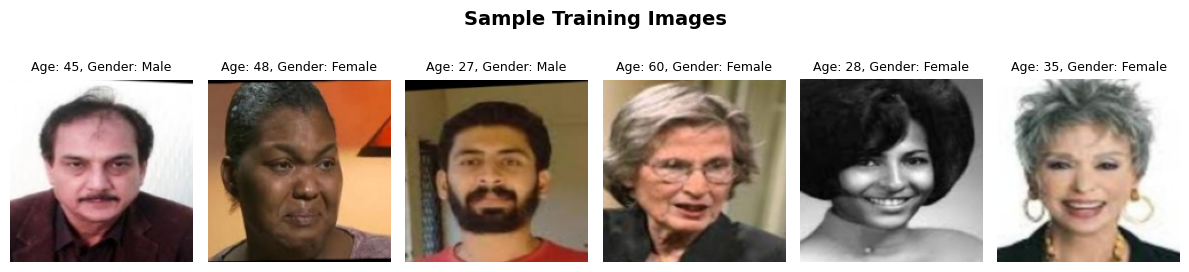

In [65]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batchSize, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batchSize, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batchSize, shuffle=True)

# Check the size of the dataset
print('Train dataset size: ', len(train_dataset))
print('Valid dataset size: ', len(valid_dataset))
print('Test dataset size: ', len(test_dataset))

# Get a batch from the train loader
images, ages, genders = next(iter(train_loader))

# Plot a few images from the batch with improved style
fig, axs = plt.subplots(1, 6, figsize=(12, 3))
fig.suptitle('Sample Training Images', fontsize=14, fontweight='bold')
for i in range(6):
    axs[i].imshow(images[i].permute(1, 2, 0).numpy())
    axs[i].set_title(f'Age: {ages[i]}, Gender: {'Female' if genders[i] else 'Male'}', fontsize=9)
    axs[i].axis('off')
fig.tight_layout()
plt.show()

You should notice that the dataset contains head images, which are larger than the face.
As a result, it is suggested to use <code>pytorch-mtcnn</code> to crop the face from the image.

Although there exist many way to use MTCNN, the following one is suggested:
* prepare a list of PIL images
* send this list to MTCNN
* MTCNN will output a list of tensors, one tensor per image, with a <code>torch.float32</code> dtype, but with pixels value in the 0..255 range (yes, integer values stored as float32)
* Note that MTCNN  resize the image as requested (cf MTCNN <code>image_size</code> argument)
* This resulting list of tensor may be converted into a single batch tensor using <code>torch.stack</code>

Define a mtcnn object to detect faces  

In [66]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=False,
    device=device
)

*Q5.* Write a function <code>faceCropping</code> that :
* receive a batch of images (tensor batchsize x channels x height x width) provided by the dataloader
* convert that tensor (batch of images) into a list of PIL images. Images may be converted using the <code>v2.ToPILImage()</code> transform.
* process the PIL image list using mtcnn
* convert the list of tensors provided by MTCNN to a single tensor containing the whole batch using <code>torch.stack</code>
* apply a transform <code>myTransform</code> to scale the data into the -1,1 range (suitable for the <code>inception-resenet-v1</code> network)  
lambda function allows applying some simple transformations to tensors : <code>myTransform=v2.Lambda(lambda x: x * 3)</code>  

Nb : part of the function code is already provided

In [67]:
myTransform = v2.Lambda(lambda x: x / 127.5 - 1.0) # Scale data into the -1..1 range

def faceCropping(mtcnn, imgsBatch, myTransform, verbose=False):
    PILBatch = [v2.ToPILImage()(img) for img in imgsBatch]
    kept_indices = list(range(len(PILBatch)))  # Assume all are kept initially
    nLost = 0
    try:
        # Process batch at once
        faces = mtcnn(PILBatch)
        imgsBatch = torch.stack(faces)
        imgsBatch = myTransform(imgsBatch)
    except:
        # Process each image individually and track kept indices
        kept_indices = []
        imgsBatch_list = []
        for i, PILimg in enumerate(PILBatch):
            try:
                data = mtcnn(PILimg)
                data = myTransform(data)
                imgsBatch_list.append(data)
                kept_indices.append(i)
            except:
                pass
        imgsBatch = torch.stack(imgsBatch_list) if imgsBatch_list else torch.empty(0)
        nLost = len(PILBatch) - len(kept_indices)
        if verbose and nLost > 0:
            print(f'{nLost} image(s) lost')
    return imgsBatch, kept_indices, nLost

Q6. write some code to get a batch from the dataloader, apply the <code>faceCropping</code> pipeline, and display the original & cropped images for some images in the batch
You may use matplotlib <code>plt.subplot</code> command to display the images into a 2 x n grid

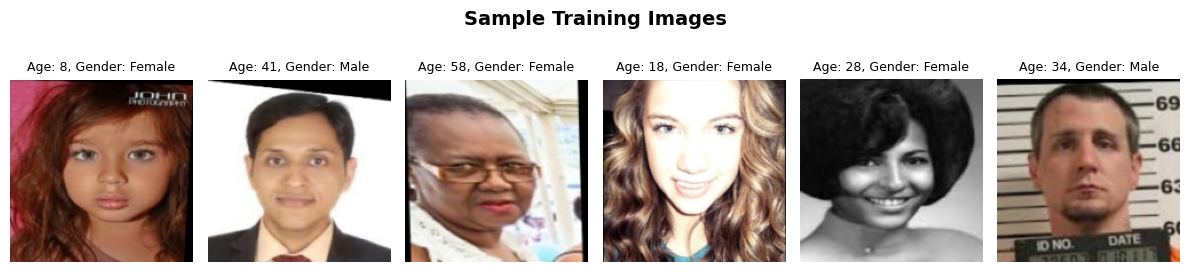

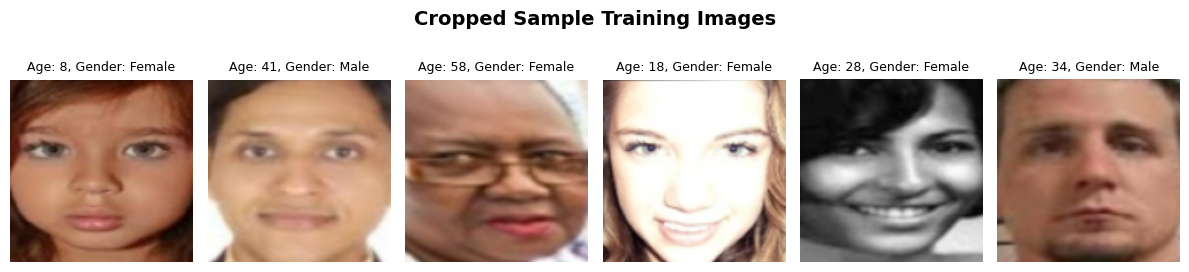

In [68]:
# Your code to get a batch of data from the dataloader and pass it through the faceCropping function
images, ages, genders = next(iter(train_loader))

# Plot a few images from the batch with improved style
fig, axs = plt.subplots(1, 6, figsize=(12, 3))
fig.suptitle('Sample Training Images', fontsize=14, fontweight='bold')
for i in range(6):
    axs[i].imshow(images[i].permute(1, 2, 0).numpy())
    axs[i].set_title(f'Age: {ages[i]}, Gender: {'Female' if genders[i] else 'Male'}', fontsize=9)
    axs[i].axis('off')
fig.tight_layout()
plt.show()

batch_img_cropped, kept_indices, nLost = faceCropping(mtcnn, images, myTransform)

# Plot a few images from the batch with improved style
fig, axs = plt.subplots(1, 6, figsize=(12, 3))
fig.suptitle('Cropped Sample Training Images', fontsize=14, fontweight='bold')
for i in range(6):
    axs[i].imshow((batch_img_cropped[i].permute(1, 2, 0).numpy()+1)*0.5) # De normalize
    axs[i].set_title(f'Age: {ages[i]}, Gender: {'Female' if genders[i] else 'Male'}', fontsize=9)
    axs[i].axis('off')
fig.tight_layout()
plt.show()

# 3 Process the dataset with the backbone

*Q7.* You need to process the 3 dataset (by using each of the 3 dataloader). This may be handled by a loop.  
For each of these dataloader, iterate over the batches and :
* Apply the <code>faceCropping</code> pipeline
* process the resulting cropped image batch with the backbone
* store  all the filenames, embeddings & age into three separate python lists.  

NB: if the filenames are stored in a tuple, you may use the following code to convert them into a list :<code>fileBatch=list(fileBatch)</code>

In [69]:
# Redefine the dataset and loaders to have all the data this time
train_dataset = myImageDataset(os.path.join(dataFolder, 'train'), H, maxImgsTrain)
valid_dataset = myImageDataset(os.path.join(dataFolder, 'validation'), H, maxImgsValid)
test_dataset  = myImageDataset(os.path.join(dataFolder, 'test'), H, maxImgsTest)

train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=batchSize, shuffle=True)
valid_loader  = torch.utils.data.DataLoader(valid_dataset, batch_size=batchSize, shuffle=True)
test_loader   = torch.utils.data.DataLoader(test_dataset, batch_size=batchSize, shuffle=True)

print('Train dataset size: ', len(train_dataset))
print('Valid dataset size: ', len(valid_dataset))
print('Test dataset size: ', len(test_dataset), '\n')

loaders = [train_loader, valid_loader, test_loader]

# Check how many images are lost in each loader
for idx, loader in enumerate(loaders):
    for i, (batch_img, batch_age, batch_gender) in enumerate(loader):
        batch_img_cropped, kept_indices, nLost = faceCropping(mtcnn, batch_img, myTransform)
        if nLost > 0:
            print(f'{nLost} image(s) lost in batch {i} of {'train' if idx == 0 else 'validation' if idx == 1 else 'test'} loader')

# Define a function to extract embeddings from a dataloader
def getEmbeddingsFromLoader(model, loader, device):
    model.to(device)
    model.eval()
    embeddings = []
    ages = []
    genders = []  # Include if gender is needed
    total_kept_indices = [] # Keep all indices for the filenames

    for batch_img, batch_age, batch_gender in loader:
        batch_img_cropped, kept_indices, nLost = faceCropping(mtcnn, batch_img, myTransform)

        # Skip if no images survived cropping
        if len(kept_indices) == 0:
            continue

        # Filter labels based on kept indices
        batch_age_filtered = batch_age[kept_indices]
        batch_gender_filtered = batch_gender[kept_indices]

        # Generate embeddings
        with torch.no_grad():
            batch_embeddings = model(batch_img_cropped.to(device))

        # Append filtered data
        embeddings.append(batch_embeddings.cpu())
        ages.append(batch_age_filtered.cpu())
        # genders.append(batch_gender_filtered.cpu())  # Optional
        total_kept_indices += kept_indices

    # Concatenate all batches
    embeddings = torch.cat(embeddings) if embeddings else torch.tensor([])
    ages = torch.cat(ages) if ages else torch.tensor([])
    # genders = torch.cat(genders) if genders else torch.tensor([])  # Optional

    return embeddings, ages, total_kept_indices

# Extract embeddings from the train, validation, and test loaders
train_embeddings, train_ages, train_kept_indices = getEmbeddingsFromLoader(backbone, train_loader, device)
valid_embeddings, valid_ages, valid_kept_indices = getEmbeddingsFromLoader(backbone, valid_loader, device)
test_embeddings, test_ages, test_kept_indices = getEmbeddingsFromLoader(backbone, test_loader, device)

# Check that embeddings and labels have same shape :
print("For train, same length ? ", len(train_embeddings) == len(train_ages))
print("For valid, same length ? ", len(valid_embeddings) == len(valid_ages))
print("For test, same length ? ", len(test_embeddings) == len(test_ages))

folder:   ../data/processed/UTKFace/train  nb files :  15994
folder:   ../data/processed/UTKFace/validation  nb files :  3444
folder:   ../data/processed/UTKFace/test  nb files :  3444
Train dataset size:  15994
Valid dataset size:  3444
Test dataset size:  3444 

1 image(s) lost in batch 21 of train loader
1 image(s) lost in batch 23 of train loader
1 image(s) lost in batch 27 of train loader
1 image(s) lost in batch 76 of train loader
1 image(s) lost in batch 109 of train loader
1 image(s) lost in batch 115 of train loader
1 image(s) lost in batch 0 of validation loader
1 image(s) lost in batch 16 of test loader
1 image(s) lost in batch 18 of test loader
1 image(s) lost in batch 19 of test loader
1 image(s) lost in batch 25 of test loader
For train, same length ?  True
For valid, same length ?  True
For test, same length ?  True


# Save data on the disk

*Q7.* Use the Pickle library to save the 3 lists onto the disk, preferably into a single file  
Cf code snipped  available in the <a href="https://moodle.uphf.fr/mod/resource/view.php?id=215344">"Python & Pytorch building block"</a> document on moodle)

In [70]:
resultFilename=os.path.join(resultFolder,embeddingFile)

# Save the embeddings and labels to a file
with open(resultFilename, 'wb') as f:
    pickle.dump((train_embeddings, train_ages, train_kept_indices, valid_embeddings, valid_ages, valid_kept_indices, test_embeddings, test_ages, test_kept_indices), f)

# Load the embeddings and labels from the file
with open(resultFilename, 'rb') as f:
    train_embeddings, train_ages, train_kept_indices, valid_embeddings, valid_ages, valid_kept_indices, test_embeddings, test_ages, test_kept_indices = pickle.load(f)

## Exploratory Data Analysis using T-SNE and PCA

## 2D plot

In [71]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define a function to plot the t-SNE of the embeddings
def plot_tsne(embeddings, labels, title='t-SNE of Embeddings', n_samples=1000):
    """
    Plots a 2D t-SNE visualization of the given embeddings, colored by labels.
    Reduces the dataset to at most n_samples points (for speed and clarity).
    
    Args:
        embeddings (torch.Tensor): Embeddings to visualize, shape (N, D).
        labels (torch.Tensor): Labels (or continuous values) for coloring, shape (N,).
        title (str): Title of the figure.
        n_samples (int): Maximum number of points to include in the plot.
    """    
    # Convert tensors to numpy arrays and move to CPU if needed
    emb_array = embeddings.detach().cpu().numpy()
    labels_array = labels.detach().cpu().numpy()
    
    # Optional subsampling for faster and less cluttered visualization
    if n_samples is not None and n_samples < emb_array.shape[0]:
        emb_idx = np.random.choice(emb_array.shape[0], n_samples, replace=False)
        emb_array = emb_array[emb_idx]
        labels_array = labels_array[emb_idx]
    
    # Standardize the embeddings before t-SNE
    emb_array = StandardScaler().fit_transform(emb_array)
    
    # Perform t-SNE (projects down to 2D)
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    emb_2d = tsne.fit_transform(emb_array)
    
    # Create the scatter plot
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels_array, cmap='viridis', alpha=0.7)
    
    # If labels are discrete/class labels, a colorbar might not be ideal. 
    # For numeric labels (e.g. age), a colorbar is informative:
    plt.colorbar(scatter, label='Labels')
    
    plt.title(title)
    plt.xlabel('t-SNE Dim 1')
    plt.ylabel('t-SNE Dim 2')
    plt.show()

# Same as before, but for PCA
def plot_pca(embeddings, labels, title='PCA of Embeddings', n_samples=1000):
    """
    Plots a 2D PCA visualization of the given embeddings, colored by labels.
    Reduces the dataset to at most n_samples points (for speed and clarity).
    
    Args:
        embeddings (torch.Tensor): Embeddings to visualize, shape (N, D).
        labels (torch.Tensor): Labels (or continuous values) for coloring, shape (N,).
        title (str): Title of the figure.
        n_samples (int): Maximum number of points to include in the plot.
    """    
    # Convert tensors to numpy arrays and move to CPU if needed
    emb_array = embeddings.detach().cpu().numpy()
    labels_array = labels.detach().cpu().numpy()
    
    # Optional subsampling for faster and less cluttered visualization
    if n_samples is not None and n_samples < emb_array.shape[0]:
        emb_idx = np.random.choice(emb_array.shape[0], n_samples, replace=False)
        emb_array = emb_array[emb_idx]
        labels_array = labels_array[emb_idx]
    
    # Standardize the embeddings before PCA
    emb_array = StandardScaler().fit_transform(emb_array)
    
    # Perform PCA (projects down to 2D)
    pca = PCA(n_components=2)
    emb_2d = pca.fit_transform(emb_array)
    
    # Create the scatter plot
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels_array, cmap='viridis', alpha=0.7)
    
    # For numeric labels (e.g. age), a colorbar is informative:
    plt.colorbar(scatter, label='Labels')
    
    plt.title(title)
    plt.xlabel('PCA Dim 1')
    plt.ylabel('PCA Dim 2')
    plt.show()

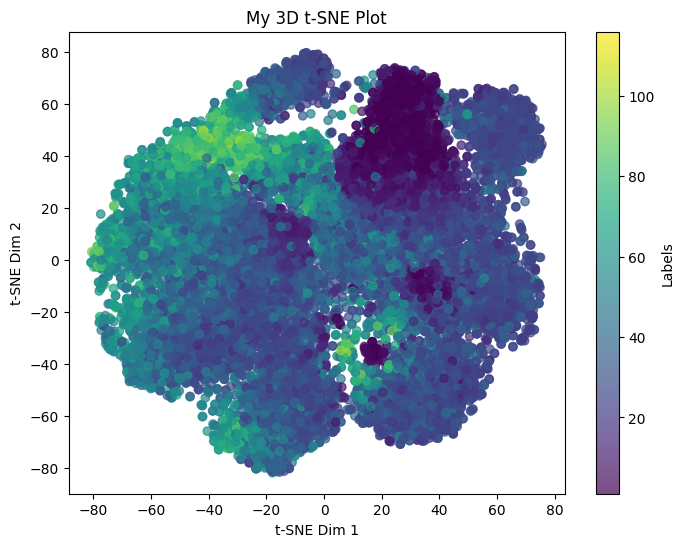

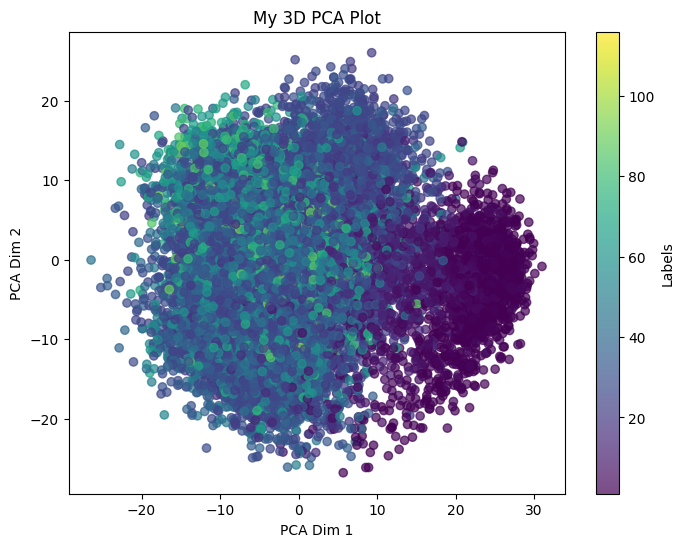

In [73]:
plot_tsne(train_embeddings, train_ages, title='My 2D t-SNE Plot', n_samples=len(train_embeddings))
plot_pca(train_embeddings, train_ages, title='My 2D PCA Plot', n_samples=len(train_embeddings))

## 3D plot

In [74]:
def plot_tsne_3d(embeddings, labels, title='3D t-SNE of Embeddings', n_samples=1000):
    """
    Plots a 3D t-SNE visualization of the given embeddings, colored by labels.
    Reduces the dataset to at most n_samples points (for speed and clarity).
    
    Args:
        embeddings (torch.Tensor): Embeddings to visualize, shape (N, D).
        labels (torch.Tensor): Labels (or continuous values) for coloring, shape (N,).
        title (str): Title of the figure.
        n_samples (int): Maximum number of points to include in the plot.
    """
    # Convert tensors to numpy arrays and move to CPU if needed
    emb_array = embeddings.detach().cpu().numpy()
    labels_array = labels.detach().cpu().numpy()

    # Optional subsampling for faster, less cluttered visualization
    if n_samples is not None and n_samples < emb_array.shape[0]:
        idx = np.random.choice(emb_array.shape[0], n_samples, replace=False)
        emb_array = emb_array[idx]
        labels_array = labels_array[idx]

    # Standardize the embeddings before t-SNE
    emb_array = StandardScaler().fit_transform(emb_array)

    # Perform t-SNE (projects down to 3D)
    tsne = TSNE(n_components=3, perplexity=30, random_state=42)
    emb_3d = tsne.fit_transform(emb_array)

    # Create the 3D scatter plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(projection='3d')
    
    scatter = ax.scatter(
        emb_3d[:, 0],
        emb_3d[:, 1],
        emb_3d[:, 2],
        c=labels_array,
        cmap='viridis',
        alpha=0.7
    )
    
    # For numeric labels (e.g., age), a colorbar is informative:
    cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
    cbar.set_label('Labels')

    ax.set_title(title)
    ax.set_xlabel('t-SNE Dim 1')
    ax.set_ylabel('t-SNE Dim 2')
    ax.set_zlabel('t-SNE Dim 3')
    plt.show()


def plot_pca_3d(embeddings, labels, title='3D PCA of Embeddings', n_samples=1000):
    """
    Plots a 3D PCA visualization of the given embeddings, colored by labels.
    Reduces the dataset to at most n_samples points (for speed and clarity).
    
    Args:
        embeddings (torch.Tensor): Embeddings to visualize, shape (N, D).
        labels (torch.Tensor): Labels (or continuous values) for coloring, shape (N,).
        title (str): Title of the figure.
        n_samples (int): Maximum number of points to include in the plot.
    """
    # Convert tensors to numpy arrays and move to CPU if needed
    emb_array = embeddings.detach().cpu().numpy()
    labels_array = labels.detach().cpu().numpy()

    # Optional subsampling for faster, less cluttered visualization
    if n_samples is not None and n_samples < emb_array.shape[0]:
        idx = np.random.choice(emb_array.shape[0], n_samples, replace=False)
        emb_array = emb_array[idx]
        labels_array = labels_array[idx]

    # Standardize the embeddings before PCA
    emb_array = StandardScaler().fit_transform(emb_array)

    # Perform PCA (projects down to 3D)
    pca = PCA(n_components=3)
    emb_3d = pca.fit_transform(emb_array)

    # Create the 3D scatter plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(projection='3d')

    scatter = ax.scatter(
        emb_3d[:, 0],
        emb_3d[:, 1],
        emb_3d[:, 2],
        c=labels_array,
        cmap='viridis',
        alpha=0.7
    )
    
    # For numeric labels (e.g., age), a colorbar is informative:
    cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
    cbar.set_label('Labels')

    ax.set_title(title)
    ax.set_xlabel('PCA Dim 1')
    ax.set_ylabel('PCA Dim 2')
    ax.set_zlabel('PCA Dim 3')
    plt.show()

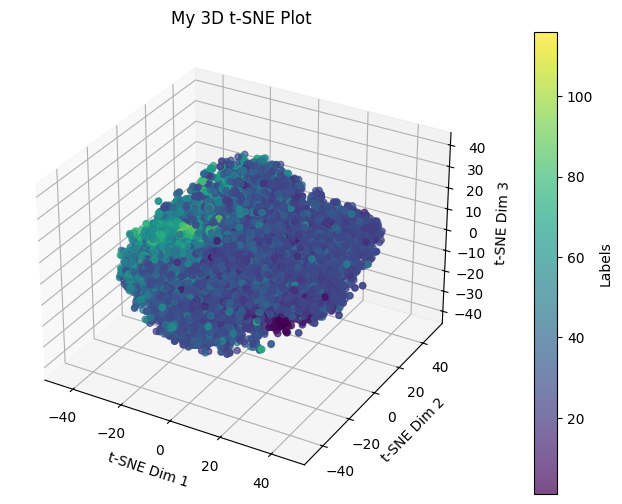

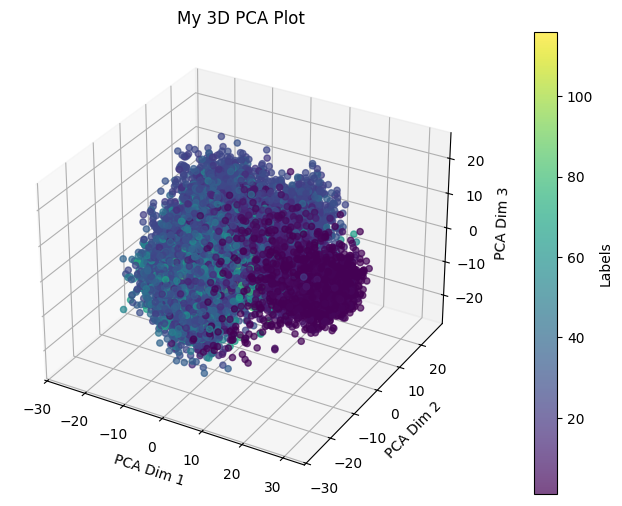

In [75]:
plot_tsne_3d(train_embeddings, train_ages, title='My 3D t-SNE Plot', n_samples=len(train_embeddings))
plot_pca_3d(train_embeddings, train_ages, title='My 3D PCA Plot', n_samples=len(train_embeddings))